<a href="https://colab.research.google.com/github/Bandariharitha/CodTechTask3/blob/main/task3_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import copy
from google.colab import drive
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def image_loader(image_path, size=(512, 512)):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device, torch.float)



In [ ]:
# Define Gram matrix, content/style loss
def gram_matrix(input):
    b, c, h, w = input.size()
    features = input.view(b * c, h * w)
    G = torch.mm(features, features.t())
    return G.div(b * c * h * w)

class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()

    def forward(self, x):
        self.loss = nn.functional.mse_loss(x, self.target)
        return x

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, x):
        G = gram_matrix(x)
        self.loss = nn.functional.mse_loss(G, self.target)
        return x


In [ ]:
# Load model and layers
cnn = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()

content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 68.0MB/s]


In [ ]:
# Build style transfer model
def get_style_model_and_losses(cnn, style_img, content_img):
    cnn = copy.deepcopy(cnn)

    content_losses = []
    style_losses = []

    model = nn.Sequential().to(device)
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        else:
            name = f'layer_{i}'

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    return model, style_losses, content_losses

In [ ]:
# Run style transfer
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300, style_weight=1e6, content_weight=1):
    model, style_losses, content_losses = get_style_model_and_losses(cnn, style_img, content_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print("Optimizing...")
    run = [0]
    while run[0] <= num_steps:
        def closure():
            optimizer.zero_grad()
            model(input_img)
            style_score = sum(sl.loss for sl in style_losses)
            content_score = sum(cl.loss for cl in content_losses)
            loss = style_score * style_weight + content_score * content_weight
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"Step {run[0]} | Style Loss: {style_score:.4f} | Content Loss: {content_score:.4f}")
            return loss

        optimizer.step(closure)

    return input_img.detach()

In [ ]:
# Upload content and style images in Colab
from google.colab import files
uploaded = files.upload()

# Example: Replace with your uploaded file names
content_image = image_loader("content2.jpeg")
style_image = image_loader("style1.jpg")
input_image = content_image.clone()

Saving content2.jpeg to content2 (1).jpeg


In [ ]:
# Run the transfer
output = run_style_transfer(cnn, content_image, style_image, input_image)

Optimizing...
Step 50 | Style Loss: 0.0000 | Content Loss: 15.5100
Step 100 | Style Loss: 0.0000 | Content Loss: 14.6881
Step 150 | Style Loss: 0.0000 | Content Loss: 13.6177
Step 200 | Style Loss: 0.0000 | Content Loss: 12.7132
Step 250 | Style Loss: 0.0000 | Content Loss: 12.1601
Step 300 | Style Loss: 0.0000 | Content Loss: 11.8069


In [ ]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


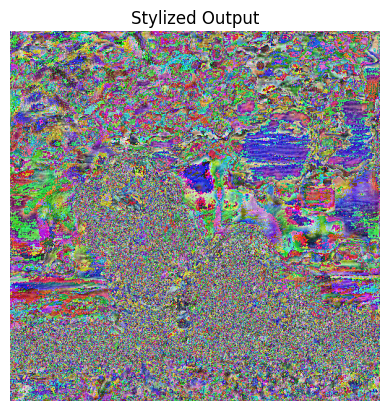

In [ ]:
# Display result
def imshow(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = transforms.ToPILImage()(image)
    if title:
        plt.title(title)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

imshow(output, title="Stylized Output")